In [46]:
import pandas as pd
import chardet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:

with open('Telemetria_Construserv_2025-09-17_jusante.csv', 'rb') as f:
    result = chardet.detect(f.read())
print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [3]:

df_jus = pd.read_csv('Telemetria_Construserv_2025-09-17_jusante.csv', encoding='ISO-8859-1',
                 sep=';',skiprows=1, skipfooter=1, engine='python', decimal=',',
                na_values = '-', parse_dates=['Unnamed: 0'], index_col='Unnamed: 0',
                dayfirst=True)

df_jus.index.name='timestamp'
df_jus.index = pd.to_datetime(df_jus.index, format="%d/%m/%Y %H:%M", dayfirst=True, errors='coerce')
#df_jus

In [4]:
df_mon = pd.read_csv('Telemetria_Construserv_2025-09-17_montante.csv', encoding='ISO-8859-1',
                 sep=';',skiprows=1, skipfooter=1, engine='python', decimal=',',
                na_values = '-', parse_dates=['Unnamed: 0'], index_col='Unnamed: 0',
                dayfirst=True)

df_mon.index.name='timestamp'
df_mon.index = pd.to_datetime(df_mon.index, format="%d/%m/%Y %H:%M", dayfirst=True, errors='coerce')
#df_mon

In [5]:
df_jus.describe()

,Precipitação (mm)**,Nível (cm),Vazão (m3/s)
count,31906.000000,31906.000000,31906.000000
mean,0.078988,119.337899,3.909092
std,0.771692,24.104387,4.752410
min,0.000000,55.000000,0.000000
25%,0.000000,104.000000,1.900000
50%,0.000000,113.000000,2.570000
75%,0.000000,125.000000,4.000000
max,42.400000,412.000000,107.120000


In [13]:
df_mon.describe()

,Precipitação (mm)**,Nível (cm),Vazão (m3/s)
count,47357.000000,47357.000000,46776.000000
mean,0.105788,145.522858,9.874709
std,1.040956,118.753912,45.600956
min,0.000000,-525.000000,0.000000
25%,0.000000,122.000000,1.720000
50%,0.000000,135.000000,4.120000
75%,0.000000,149.000000,5.230000
max,63.000000,1035.000000,368.860000


# Visualização das Séries

In [14]:
def plot_series(df_jus, df_mon):
    
    plt.figure(figsize=(12,8))
    plt.subplot(2,1,1)
    plt.plot(df_jus.index, df_jus["Nível (cm)"])

    locator = mdates.MonthLocator(bymonthday=1)
    formatter = mdates.DateFormatter("%m/%Y")
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)
    
    plt.title("Nível a jusante")
    plt.ylabel("Nível (cm)")
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(df_mon.index, df_mon["Nível (cm)"])
    
    locator = mdates.MonthLocator(bymonthday=1)
    formatter = mdates.DateFormatter("%m/%Y")
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)
    
    plt.title("Nível a montante")
    plt.ylabel("Nível (cm)")
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


def plot_violin(df, estacao):
    plt.figure(figsize=(8,6))
    sns.violinplot(y=df["Nível (cm)"], bw_method=0.4, color='skyblue')
    plt.title(f'Distribuição de Nível a {estacao}')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.axhline(y=df['Nível (cm)'].median(), color='red', linestyle='--', linewidth=1.5, label='Mediana')
    plt.axhline(y=df['Nível (cm)'].quantile(0.25), color='green', linestyle='--', linewidth=1.5, label='Q1 (25%)')
    plt.axhline(y=df['Nível (cm)'].quantile(0.75), color='orange', linestyle='--', linewidth=1.5, label='Q3 (75%)')
    
    plt.legend()
    plt.show()

C:\Users\ksilva\AppData\Local\Temp\ipykernel_17328\3371555498.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\ksilva\AppData\Local\Temp\ipykernel_17328\3371555498.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


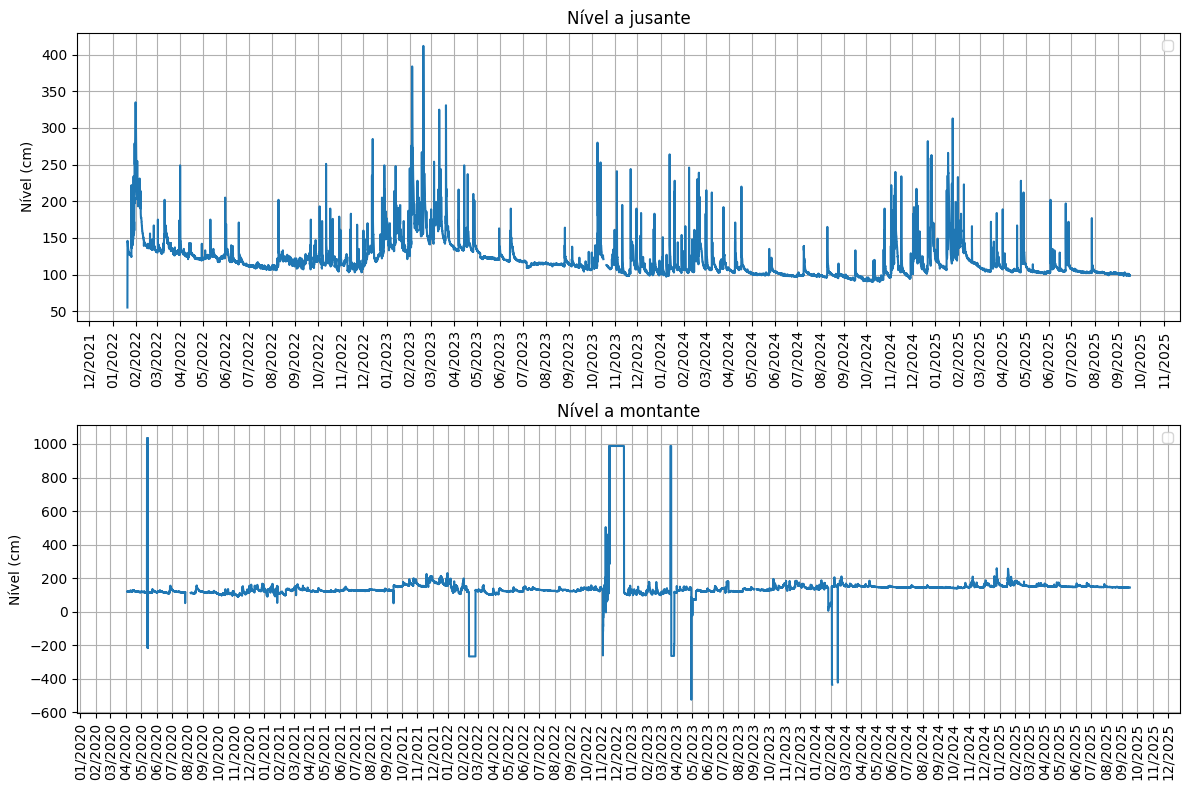

In [12]:
plot_series(df_jus, df_mon)

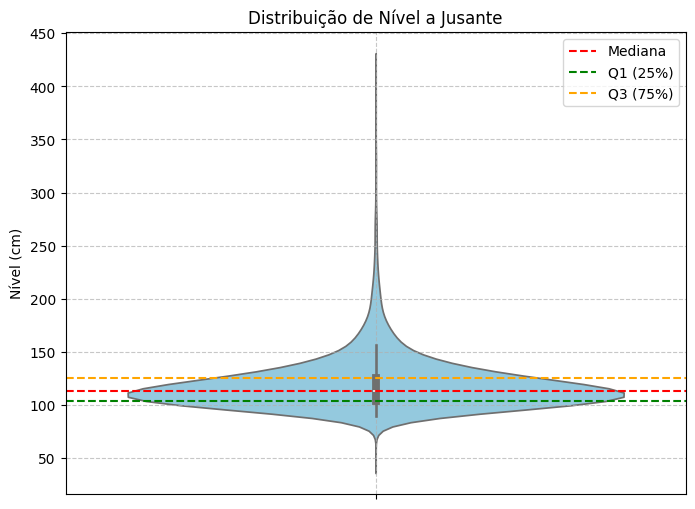

In [16]:
plot_violin(df_jus, 'Jusante')

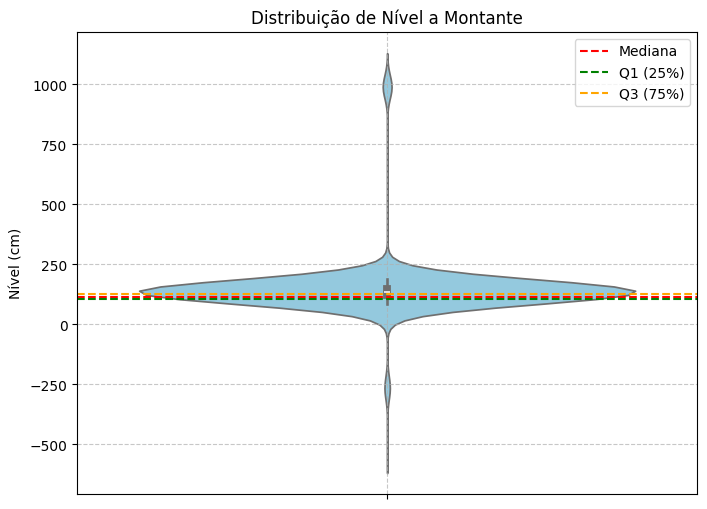

In [17]:
plot_violin(df_mon, 'Montante')

## Tratamento Outlyers

In [18]:
def tratar_outliers_iqr(df, coluna, fator=1.5, q1=0.05, q3=0.95):

    df_copy = df.copy()
    
    Q1 = df_copy[coluna].quantile(q1)
    Q3 = df_copy[coluna].quantile(q3)
    IQR = Q3 - Q1
    
    limite_inferior = Q1 - fator * IQR
    limite_superior = Q3 + fator * IQR

    # média apenas dos valores válidos (não outliers, >=0 e <=800)
    media_valida = df_copy[coluna][(df_copy[coluna] >= 0) & 
                                   (df_copy[coluna] >= limite_inferior) & 
                                   (df_copy[coluna] <= limite_superior) & 
                                   (df_copy[coluna] <= 800)].mean()
    
    # substitui valores inválidos pela média válida
    df_copy[coluna] = df_copy[coluna].mask((df_copy[coluna] < 0) | 
                                           (df_copy[coluna] < limite_inferior) | 
                                           (df_copy[coluna] > limite_superior) |
                                           (df_copy[coluna] > 800),
                                           media_valida)
    
    return df_copy


In [19]:
def preencher_nans(df, coluna):

    df_copy = df.copy()
    media = df_copy[coluna].mean()
    df_copy[coluna] = df_copy[coluna].fillna(media)
    return df_copy

In [40]:
df_mon_filt = tratar_outliers_iqr(df_mon, 'Nível (cm)', q1=0.15, q3=0.85)
df_jus_filt = tratar_outliers_iqr(df_jus, 'Nível (cm)', q1=0.15, q3=0.85)
df_mon_filt = preencher_nans(df_mon_filt, 'Nível (cm)')
df_jus_filt = preencher_nans(df_jus_filt, 'Nível (cm)')

## Visualização de série filtrada

C:\Users\ksilva\AppData\Local\Temp\ipykernel_17328\3855019076.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\ksilva\AppData\Local\Temp\ipykernel_17328\3855019076.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


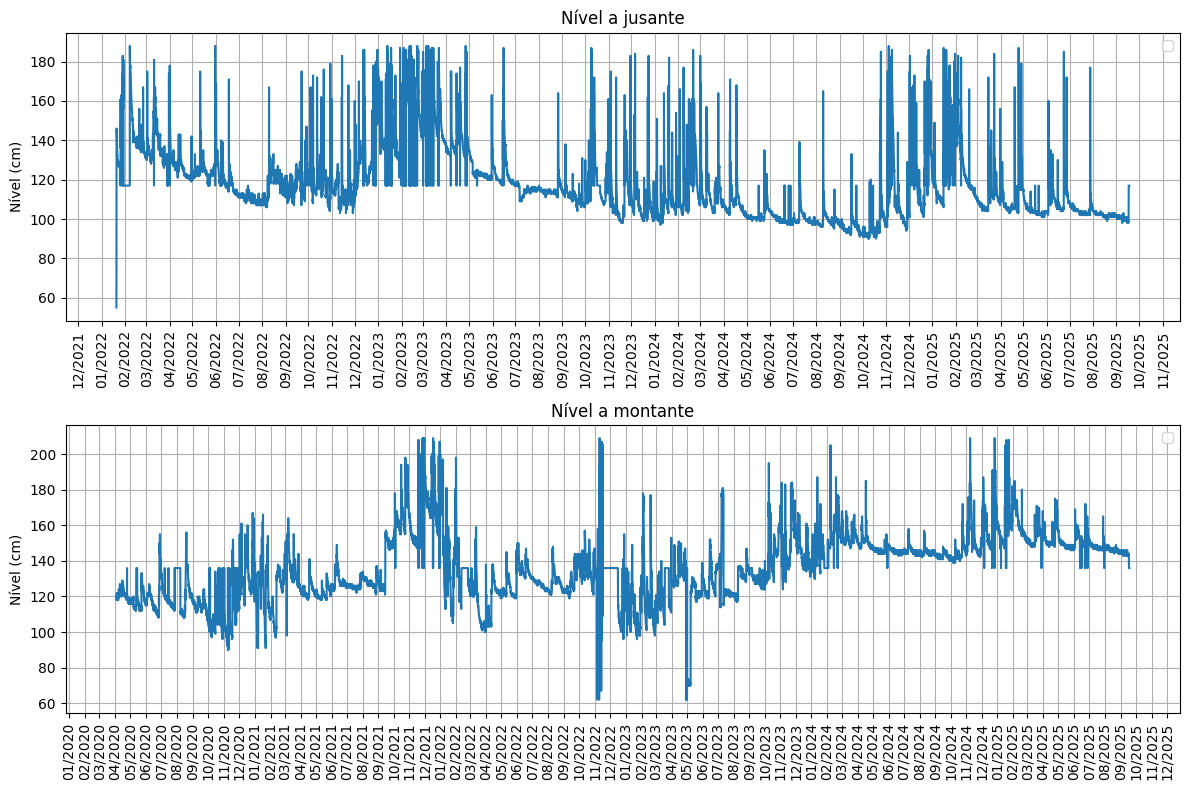

In [41]:
plot_series(df_jus_filt, df_mon_filt)

## Análise de Lags


In [35]:

def plot_acf_pacf(serie, lags=40):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    plot_acf(serie, lags=lags, ax=axes[0])
    plot_pacf(serie, lags=lags, ax=axes[1])
    axes[0].set_title('ACF')
    axes[1].set_title('PACF')
    plt.tight_layout()
    plt.show()


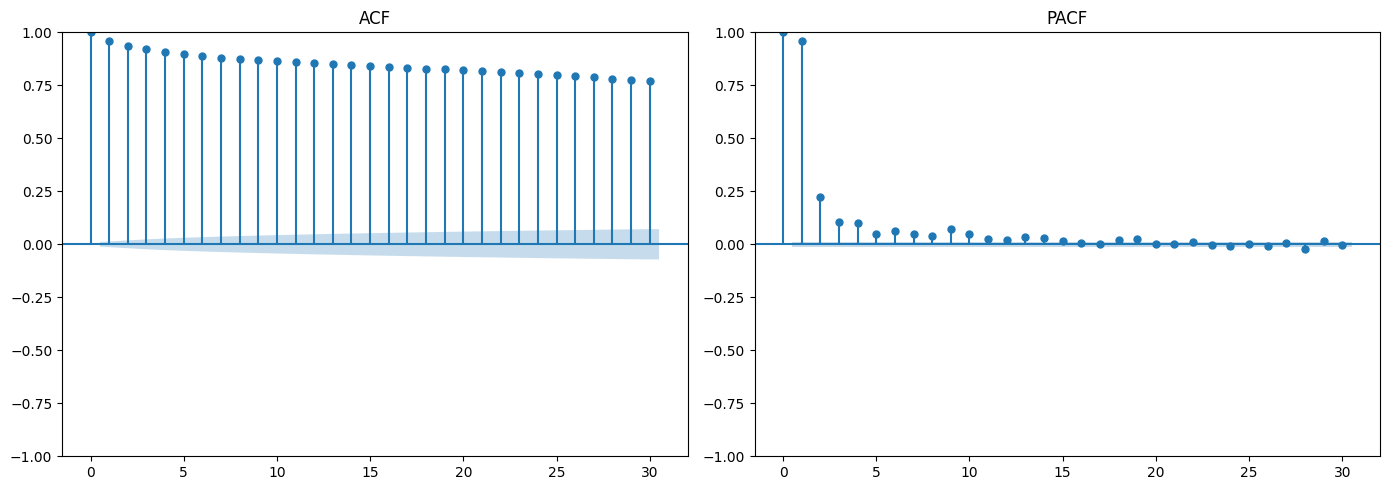

In [36]:
plot_acf_pacf(df_jus_filt['Nível (cm)'], lags=30)

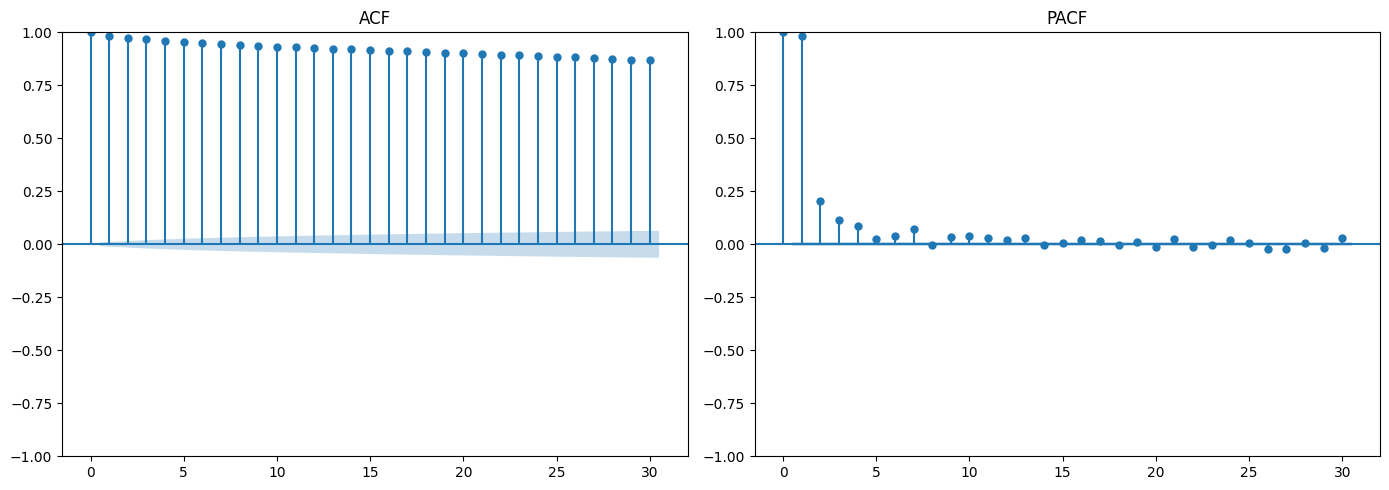

In [37]:
plot_acf_pacf(df_mon_filt['Nível (cm)'], lags=30)

# Decomposição das Séries

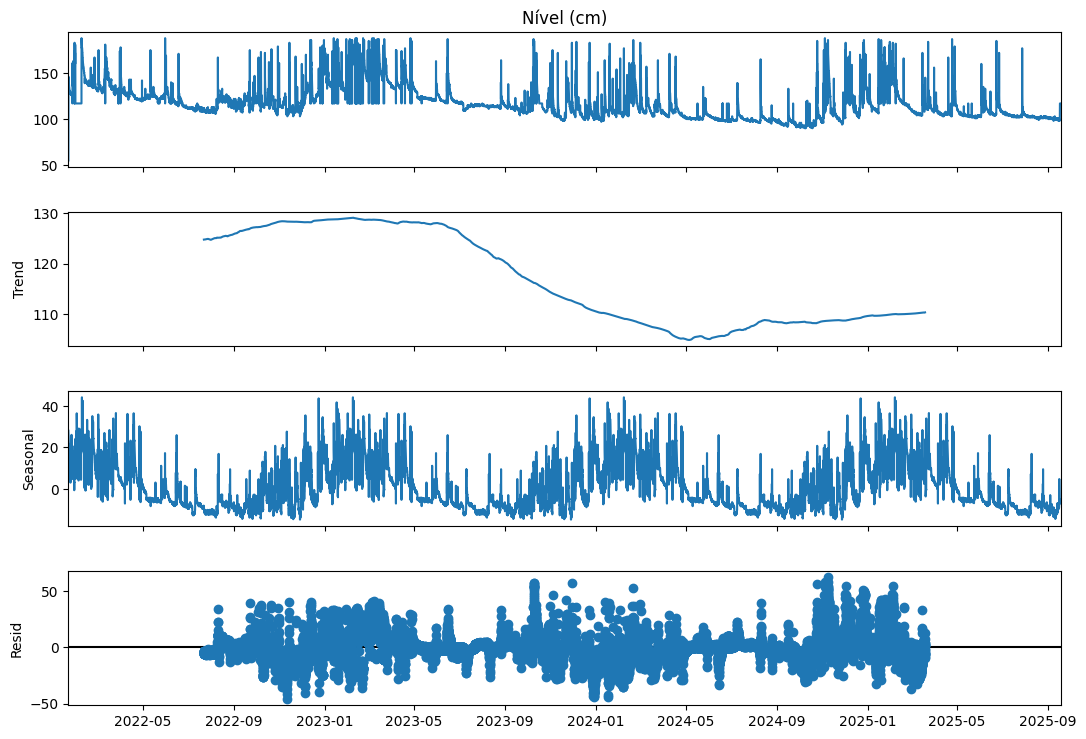

In [42]:
result = seasonal_decompose(df_jus_filt['Nível (cm)'], model='additive', period=365*24)

# Plot
fig = result.plot()
fig.set_size_inches(12, 8)
plt.show()

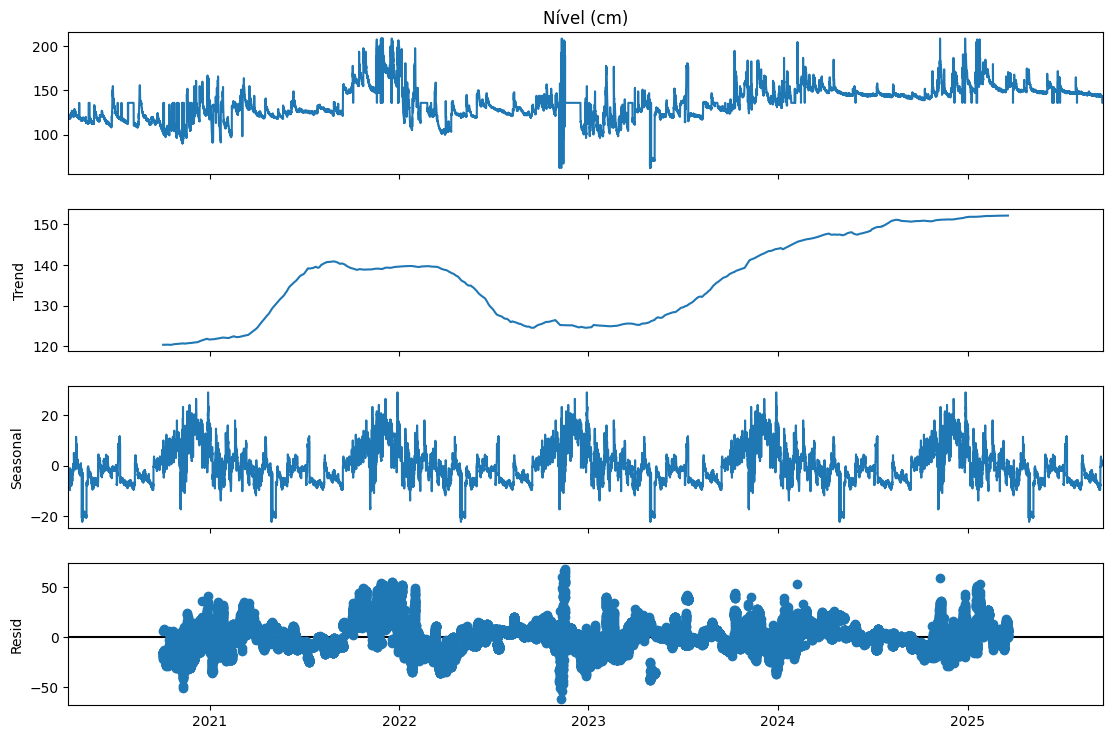

In [43]:
result = seasonal_decompose(df_mon_filt['Nível (cm)'], model='additive', period=365*24)

# Plot
fig = result.plot()
fig.set_size_inches(12, 8)
plt.show()

# Teste Arima

In [58]:
def teste_ADF(serie):
    
    # Teste ADF na série original
    adf_original = adfuller(serie.dropna())
    print("ADF (série original)")
    print(f"Estatística: {adf_original[0]:.4f}")
    print(f"p-valor: {adf_original[1]:.4f}")
    
    # Teste ADF após diferenciação de ordem 1
    serie_diff = serie.diff().dropna()
    adf_diff = adfuller(serie_diff)
    print("\nADF (série diferenciada)")
    print(f"Estatística: {adf_diff[0]:.4f}")
    print(f"p-valor: {adf_diff[1]:.4f}")

In [85]:
def train_test_arima(serie, order=(1,1,0)):
        
    train = serie.iloc[:-168]
    test = serie.iloc[-168:]
    
    # Ajustar ARIMA no treino
    modelo = ARIMA(train, order=order)
    resultado = modelo.fit(cov_type='robust')
    print(resultado.summary())
    
    forecast = resultado.get_forecast(steps=168)
    pred = forecast.predicted_mean
    ic = forecast.conf_int()
    
    # Comparação
    plt.figure(figsize=(12,6))
    #plt.plot(train.index, train, label='Treino')
    plt.plot(test.index, test, label='Teste (Real)', color='black')
    plt.plot(test.index, pred, label='Previsão', color='green')
    plt.fill_between(test.index, ic.iloc[:,0], ic.iloc[:,1], 
                     color='gray', alpha=0.3, label='Intervalo Conf.')
    plt.legend()
    plt.show()
    
    rmse = np.sqrt(mean_squared_error(test, pred))
    mae = mean_absolute_error(test, pred)
    erro_max = np.max(np.abs(test - pred))
    
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"Erro máximo: {erro_max:.2f}")
    


## Teste Jusante

C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                31904
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -98091.402
Date:                Wed, 01 Oct 2025   AIC                         196186.804
Time:                        15:15:53   BIC                         196203.545
Sample:                    01-20-2022   HQIC                        196192.160
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2460      0.023    -10.686      0.000      -0.291      -0.201
sigma2        27.4254      1.476     18.577      0.000      24.532      30.319
Ljung-Box (L1) (Q):                  18.80   Jarque-

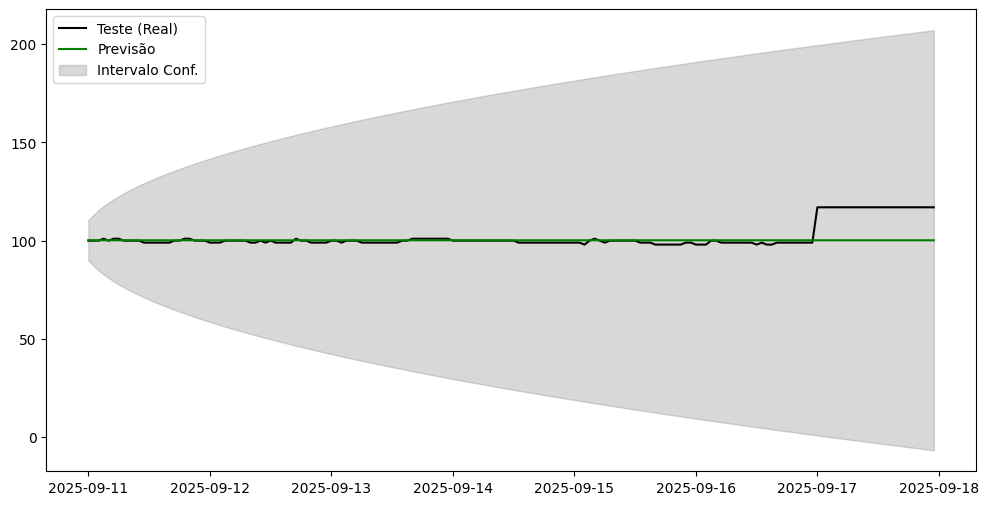

RMSE: 6.42
MAE: 3.16
Erro máximo: 16.79


In [84]:
train_test_arima(df_jus_filt['Nível (cm)'], order=(1,1,0))

C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                31904
Model:                 ARIMA(4, 1, 0)   Log Likelihood              -97476.472
Date:                Wed, 01 Oct 2025   AIC                         194962.943
Time:                        15:13:06   BIC                         195004.796
Sample:                    01-20-2022   HQIC                        194976.333
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2990      0.023    -12.726      0.000      -0.345      -0.253
ar.L2         -0.1568      0.020     -8.002      0.000      -0.195      -0.118
ar.L3         -0.1506      0.020     -7.567      0.0

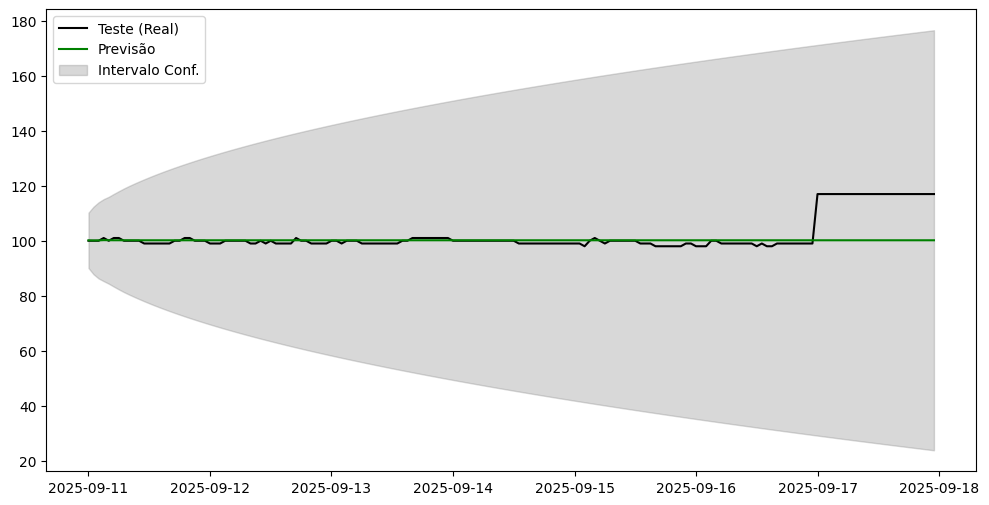

RMSE: 6.43
MAE: 3.14
Erro máximo: 16.81


In [78]:
train_test_arima(df_jus_filt['Nível (cm)'], order=(4,1,0))

A melhor configuração para o modelo de justante é a ordem 4,1,0 do ARIMA. Chama a atenção a heterocedasticidade. O que torna os intervalos de confiança menos confiáveis. Para mitigar este efeito foi definido o Covariance Type: robust.

## Teste Montante

C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                47673
Model:                 ARIMA(1, 1, 0)   Log Likelihood             -124433.537
Date:                Wed, 01 Oct 2025   AIC                         248871.073
Time:                        15:17:17   BIC                         248888.618
Sample:                    04-03-2020   HQIC                        248876.581
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2405      0.033     -7.237      0.000      -0.306      -0.175
sigma2        10.8324      0.766     14.143      0.000       9.331      12.334
Ljung-Box (L1) (Q):                  46.19   Jarque-

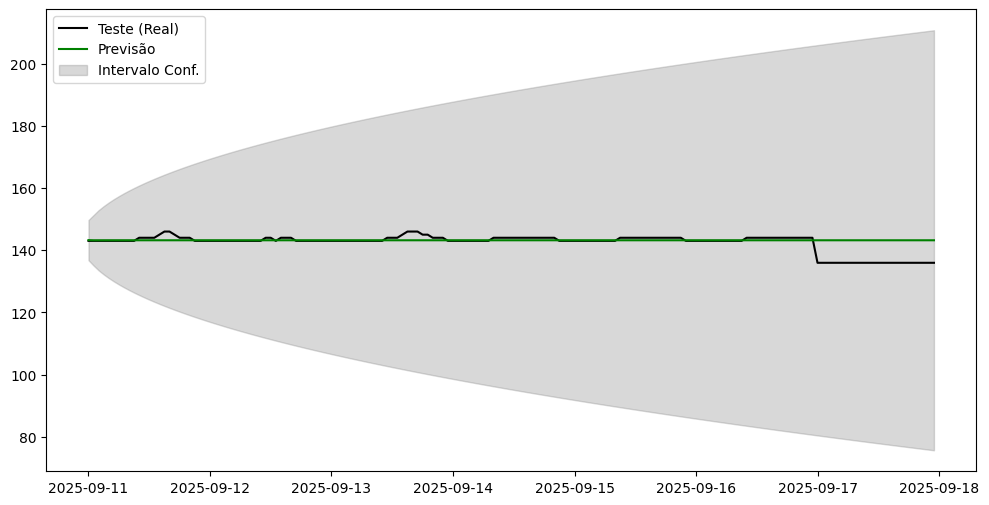

RMSE: 2.84
MAE: 1.54
Erro máximo: 7.24


In [86]:
train_test_arima(df_mon_filt['Nível (cm)'], order=(1,1,0))

C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Nível (cm)   No. Observations:                47673
Model:                 ARIMA(4, 1, 0)   Log Likelihood             -123749.611
Date:                Wed, 01 Oct 2025   AIC                         247509.222
Time:                        15:18:42   BIC                         247553.083
Sample:                    04-03-2020   HQIC                        247522.992
                         - 09-10-2025                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2888      0.033     -8.626      0.000      -0.354      -0.223
ar.L2         -0.1632      0.029     -5.544      0.000      -0.221      -0.106
ar.L3         -0.1078      0.030     -3.562      0.0

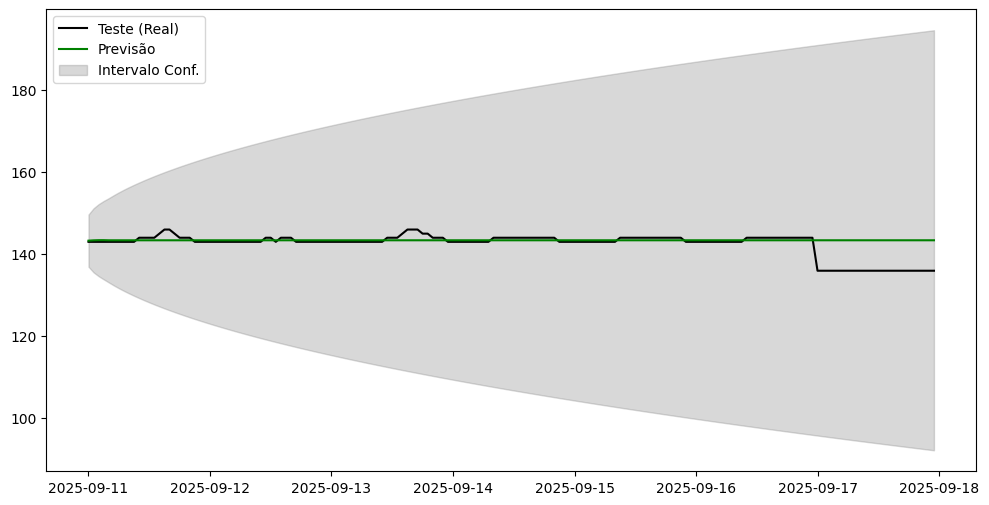

RMSE: 2.89
MAE: 1.57
Erro máximo: 7.43


In [87]:
train_test_arima(df_mon_filt['Nível (cm)'], order=(4,1,0))

A melhor configuração para o modelo de montante é a ordem 1,1,0 do ARIMA. Chama a atenção a heterocedasticidade. O que torna os intervalos de confiança menos confiáveis. Para mitigar este efeito foi definido o Covariance Type: robust.

# Teste Rolling Forecast

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rolling_forecast_arima(serie, order=(1,1,0), steps=168, start=31904):
    """
    Faz previsões semanais (steps=168) com ARIMA, atualizando o modelo
    com os dados reais da semana prevista. 
    A última previsão pode ser menor que 'steps'.
    """
    
    resultados = []

    while start + steps < len(serie):
        # tamanho da janela de previsão (pode ser < steps na última iteração)
        horizon = min(steps, len(serie) - (start + steps))

        # definir treino e teste
        train = serie.iloc[:start+steps]
        test = serie.iloc[start+steps:start+steps+horizon]

        # treinar ARIMA
        modelo = ARIMA(train, order=order)
        resultado = modelo.fit(cov_type="robust")

        # forecast
        forecast = resultado.get_forecast(steps=horizon)
        pred = forecast.predicted_mean
        ic = forecast.conf_int()

        # plotar
        plt.figure(figsize=(12,6))
        plt.plot(test.index, test, label="Teste (Real)", color="black")
        plt.plot(test.index, pred, label="Previsão", color="green")
        plt.fill_between(test.index, ic.iloc[:,0], ic.iloc[:,1],
                         color="gray", alpha=0.3, label="Intervalo Conf.")
        plt.title(f"Previsão semana {start//steps + 1}")
        plt.legend()
        plt.show()

        # métricas
        rmse = np.sqrt(mean_squared_error(test, pred))
        mae = mean_absolute_error(test, pred)
        erro_max = np.max(np.abs(test - pred))

        print(f"Semana {start//steps + 1}:")
        print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, Erro Máx: {erro_max:.2f}\n")

        resultados.append({
            "semana": start//steps + 1,
            "rmse": rmse,
            "mae": mae,
            "erro_max": erro_max
        })

        # avançar janela
        start += steps

    return resultados


In [109]:
df_jus_test = pd.read_csv('Telemetria_Construserv_2025-10-01.csv', encoding='ISO-8859-1',
                 sep=';',skiprows=1, skipfooter=1, engine='python', decimal=',',
                na_values = '-', parse_dates=['Unnamed: 0'], index_col='Unnamed: 0',
                dayfirst=True)

df_jus_test.index.name='timestamp'
df_jus_test.index = pd.to_datetime(df_jus_test.index, format="%d/%m/%Y %H:%M", dayfirst=True, errors='coerce')
#df_jus_test

In [110]:
df_mon_test = pd.read_csv('Telemetria_Construserv_2025-10-01_montante.csv', encoding='ISO-8859-1',
                 sep=';',skiprows=1, skipfooter=1, engine='python', decimal=',',
                na_values = '-', parse_dates=['Unnamed: 0'], index_col='Unnamed: 0',
                dayfirst=True)

df_mon_test.index.name='timestamp'
df_mon_test.index = pd.to_datetime(df_mon_test.index, format="%d/%m/%Y %H:%M", dayfirst=True, errors='coerce')
#df_jus_test



In [117]:
df_mon_test = tratar_outliers_iqr(df_mon_test, 'Nível (cm)', q1=0.15, q3=0.85)
df_jus_test = tratar_outliers_iqr(df_jus_test, 'Nível (cm)', q1=0.15, q3=0.85)
df_mon_test = preencher_nans(df_mon_test, 'Nível (cm)')
df_jus_test = preencher_nans(df_jus_test, 'Nível (cm)')

## Previsões a Jusante

C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


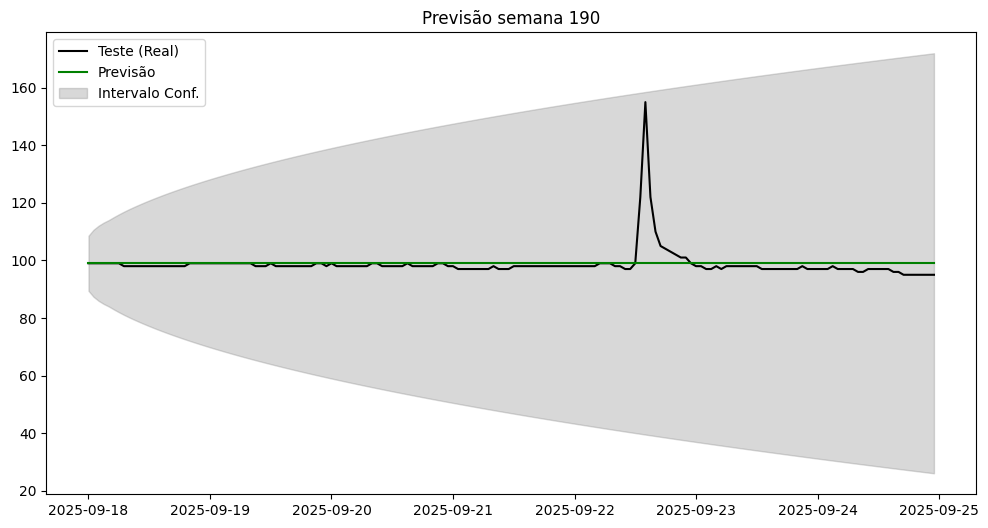

Semana 190:
RMSE: 5.33, MAE: 1.93, Erro Máx: 56.00



C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


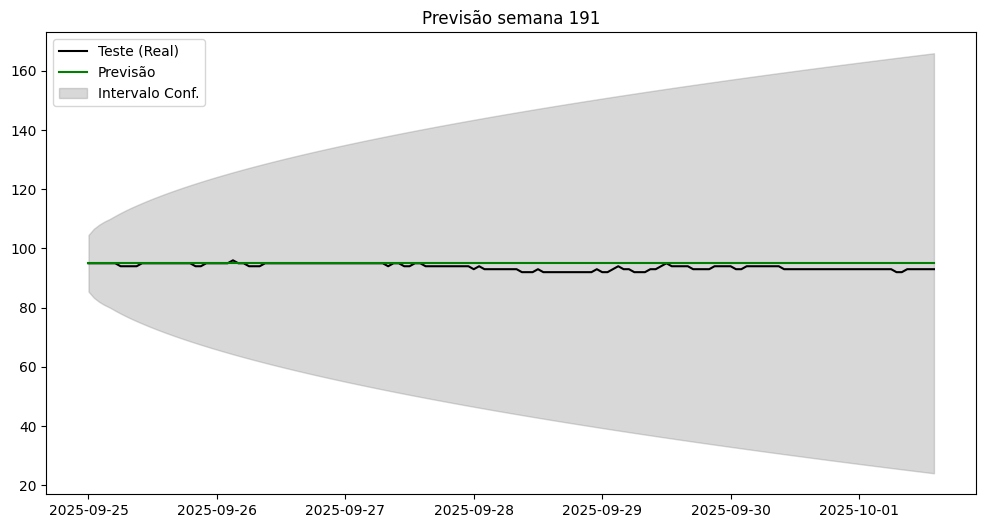

Semana 191:
RMSE: 1.61, MAE: 1.23, Erro Máx: 3.00



[{'semana': 190,
  'rmse': np.float64(5.33463525775974),
  'mae': np.float64(1.9345238095238095),
  'erro_max': np.float64(56.0)},
 {'semana': 191,
  'rmse': np.float64(1.6097189097955764),
  'mae': np.float64(1.2327044025157232),
  'erro_max': np.float64(3.0)}]

In [118]:
rolling_forecast_arima(df_jus_test['Nível (cm)'], order=(4,1,0), steps=168, start=31904)

## Previsões a Montante

C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


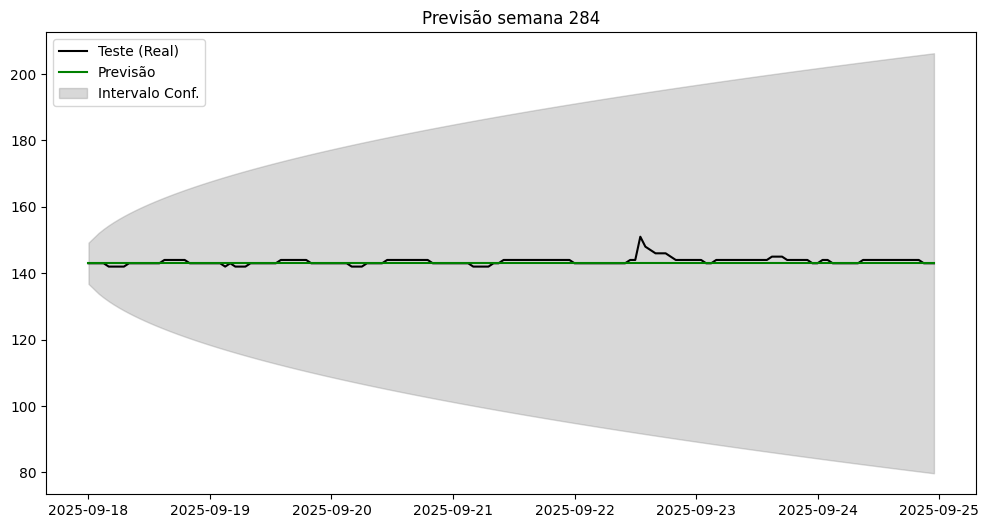

Semana 284:
RMSE: 1.18, MAE: 0.72, Erro Máx: 8.00



C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\ksilva\.conda\envs\mlflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


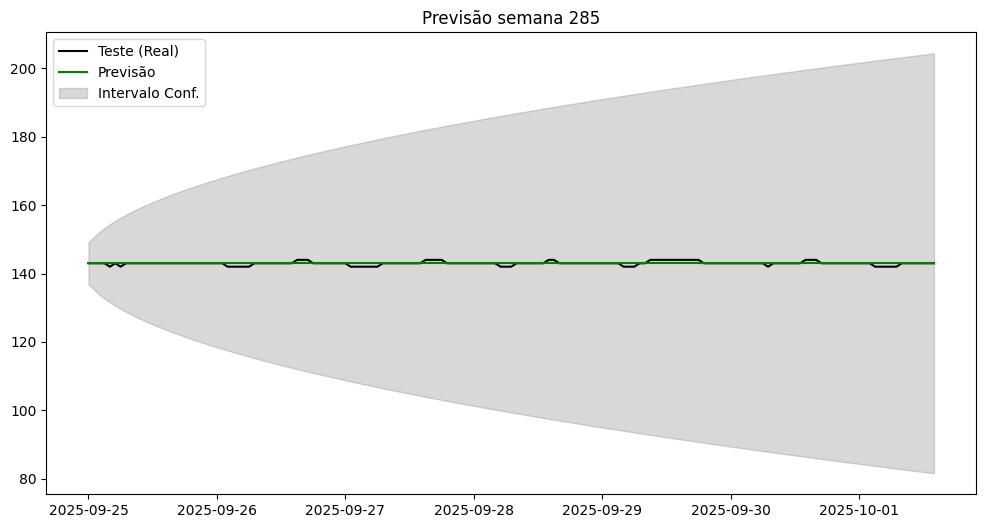

Semana 285:
RMSE: 0.54, MAE: 0.30, Erro Máx: 1.00



[{'semana': 284,
  'rmse': np.float64(1.1827127816209326),
  'mae': np.float64(0.7202380952380952),
  'erro_max': np.float64(8.0)},
 {'semana': 285,
  'rmse': np.float64(0.5436887751983938),
  'mae': np.float64(0.29559748427672955),
  'erro_max': np.float64(1.0)}]

In [121]:
rolling_forecast_arima(df_mon_test['Nível (cm)'], order=(1,1,0), steps=168, start=47673)

In [119]:
df_mon_test

,Precipitação (mm)**,Nível (cm),Vazão (m3/s)
timestamp,,,
2020-04-03 15:00:00,0.0,120.0,1.64
2020-04-03 16:00:00,0.0,120.0,1.64
2020-04-03 17:00:00,0.0,120.0,1.64
2020-04-03 18:00:00,0.0,120.0,1.64
2020-04-03 19:00:00,0.0,120.0,1.64
...,...,...,...
2025-10-01 10:00:00,0.0,143.0,1.01
2025-10-01 11:00:00,0.0,143.0,1.01
2025-10-01 12:00:00,0.0,143.0,1.01


In [120]:
df_mon[:-168]

,Precipitação (mm)**,Nível (cm),Vazão (m3/s)
timestamp,,,
2020-04-03 15:00:00,0.0,120.0,1.64
2020-04-03 16:00:00,0.0,120.0,1.64
2020-04-03 17:00:00,0.0,120.0,1.64
2020-04-03 18:00:00,0.0,120.0,1.64
2020-04-03 19:00:00,0.0,120.0,1.64
...,...,...,...
2025-09-10 19:00:00,0.0,144.0,1.12
2025-09-10 20:00:00,0.0,144.0,1.12
2025-09-10 21:00:00,0.0,144.0,1.12


In [97]:

len(df_jus_filt.iloc[:-168])

31904

In [108]:
df_mon

,Precipitação (mm)**,Nível (cm),Vazão (m3/s)
timestamp,,,
2020-04-03 15:00:00,0.0,120.0,1.64
2020-04-03 16:00:00,0.0,120.0,1.64
2020-04-03 17:00:00,0.0,120.0,1.64
2020-04-03 18:00:00,0.0,120.0,1.64
2020-04-03 19:00:00,0.0,120.0,1.64
...,...,...,...
2025-09-17 19:00:00,NaN,NaN,NaN
2025-09-17 20:00:00,NaN,NaN,NaN
2025-09-17 21:00:00,NaN,NaN,NaN


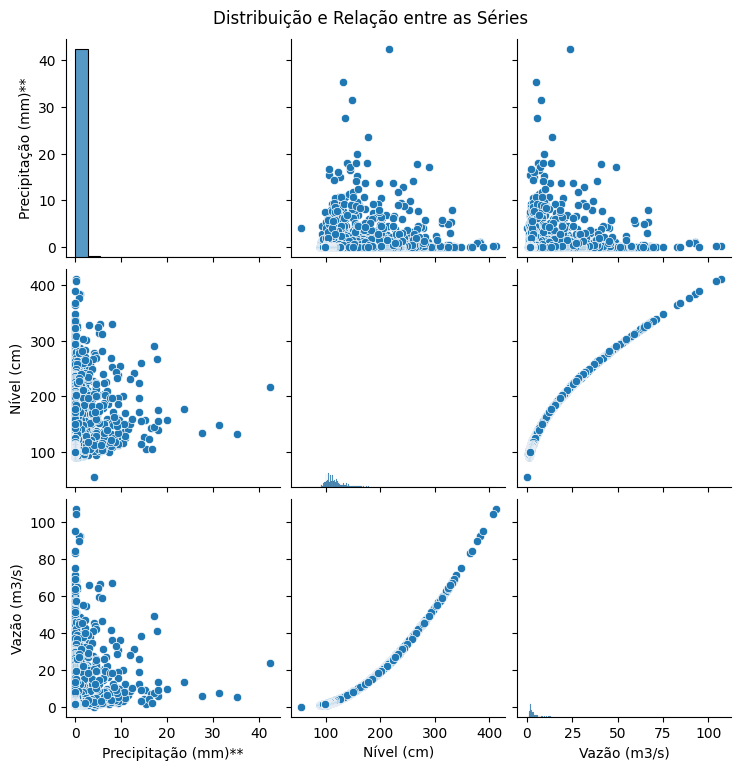

In [23]:
# Cria o pairplot para as colunas de interesse
sns.pairplot(df[['Precipitação (mm)**', 'Nível (cm)', 'Vazão (m3/s)']])

plt.suptitle('Distribuição e Relação entre as Séries', y=1.02) # Título acima dos plots
plt.show()

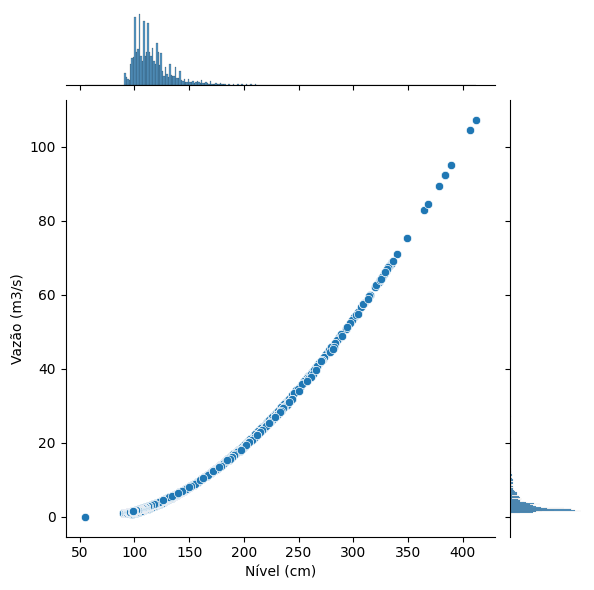

In [24]:
sns.jointplot(data=df, x='Nível (cm)', y='Vazão (m3/s)', kind='scatter')

plt.show()

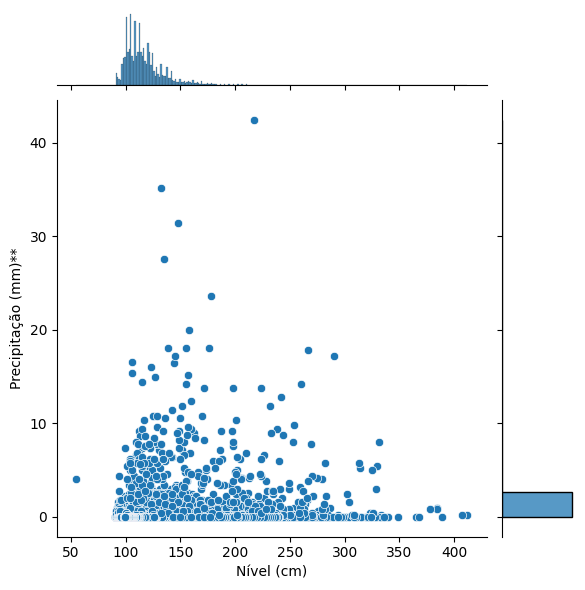

In [25]:
sns.jointplot(data=df, x='Nível (cm)', y='Precipitação (mm)**', kind='scatter')

plt.show()